/Users/yukiharuta/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


sPV0.18
FWHM: 15.3, R2: 0.9945
sPV0.48
FWHM: 37.4, R2: 0.9961
SLOW: N=42, FAST: N=21
slow
median: 19.572329798204045
iqr: 7.5343954650190526
fast
median: 28.13026365274684
iqr: 14.0486447449912


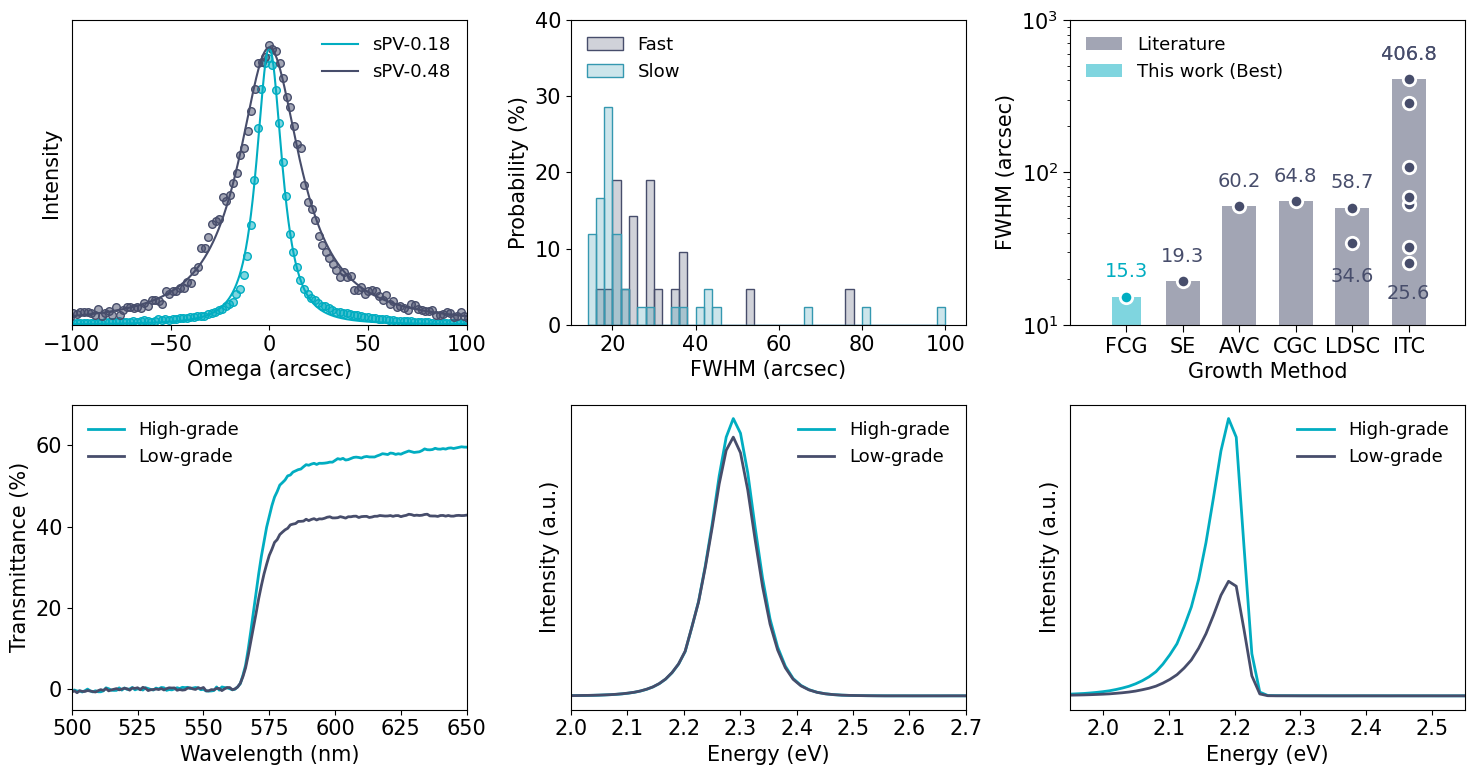

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import wofz, gamma
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# figure save option
save_option = True
figsavepath = "../Figures/Figure5_crystal-evaluation.svg"

# Panel A Representative Rocking Curves
pathA1 = '../Data/Figure5/231010_AY4_0.2mmh_100omega.csv'  #sPV0.18, fwhm15.3, R2 0.995
pathA2 = '../Data/Figure5/230330_A_-0.4mmh-100omega.csv' #sPV0.48, fwhm37.4, R2 0.996

# Panel B FWHM BOX PLOT ###
# check FWHM-analysis.ipynb
pathB1 = '../Data/Figure5/FWHM-analysis.csv'

# Panel C XRC-comparison
pathC = '../Data/Figure5/literature-XRC.xlsx'

# Panel D Transmittance
pathD1 = '../Data/Figure5/230811-A.Sample.csv' # high grade
pathD2 = '../Data/Figure5/230907-D.Sample.csv' # low grade

# Panel E Single-Photon PL
pathE1 = '../Data/Figure5/230811_A_SP_405nm_0.25_power_2.txt' # high grade
pathE2 = '../Data/Figure5/2309007_D_SP_405nm_0.25_power_2.txt' # low grade

# Panel F Two-Photon PL
pathF1 = '../Data/Figure5/230811_A_2P_800nm_0.4_power_inside.txt' # high grade
pathF2 = '../Data/Figure5/2309007_D_2P_800nm_0.4_power_inside.txt' # low grade

# define the PearsonVII function for the fitting of rocking curves
# https://www.originlab.com/doc/Origin-Help/PearsonVII-FitFunc
def PearsonVII(x, xc, y0, A, mu, w):
    y = y0 + A*(2*gamma(mu)*np.sqrt(2**(1/mu)-1))/np.sqrt(np.pi)/gamma(mu-0.5)/w*(1+4*(2**(1/mu)-1)/w/w*(x-xc)**2)**(-mu)
    return y

def fitting(x,y):
    # fit the PearsonVII function to the data
    popt, pcov = curve_fit(PearsonVII, x, y, p0=[0, 0, 30, 1, 30])
    # Fitted Parameters
    xc_fit, y0_fit, A_fit, mu_fit, w_fit = popt
    # Fitting curve
    X = np.arange(np.min(x),np.max(x),0.1)
    Y = PearsonVII(X, *popt)
    # normalize again based on fitting
    x = [n-xc_fit for n in x]
    y = [n/max(Y) for n in y]
    
    ### Second fitting ###
    # fit the PearsonVII function to the data
    popt, pcov = curve_fit(PearsonVII, x, y, p0=[0, 0, 30, 1, 30])
    # Fitted Parameters
    xc_fit, y0_fit, A_fit, mu_fit, w_fit = popt
    
    # calculate R-squared value
    y_fit = PearsonVII(x, *popt)
    R2 = r2_score(y, y_fit)

    # Extract FWHM
    FWHM = w_fit
    # Fitting curve
    X = np.arange(np.min(x),np.max(x),0.1)
    Y = PearsonVII(X, *popt)
    
    print(f'FWHM: {FWHM:.1f}, R2: {R2:.4f}')
    return x, y, X, Y

### Design ###
BG = "#474D6B" # blue gray
LB = "#01ADC1" # light blue
lw = 2 # linewidth for panel D, E, F

### Data read
"""
Panel A
"""
df1 = pd.read_csv(pathA1)
df2 = pd.read_csv(pathA2)
x_a1 = df1['NORM_omega'].to_list()
y_a1 = df1['NORM'].to_list()
x_a2 = df2['NORM_omega'].to_list()
y_a2 = df2['NORM'].to_list()
x_a1 = [n*3600 for n in x_a1]
x_a2 = [n*3600 for n in x_a2]

print('sPV0.18')
x_a1, y_a1, X_a1_fit, Y_a1_fit = fitting(x_a1, y_a1)
print('sPV0.48')
x_a2, y_a2, X_a2_fit, Y_a2_fit = fitting(x_a2, y_a2)

### Figure Plot ###
plt.rcParams["font.size"] = 15
fig, axes = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,8))

# Rocking curves
axes[0][0].plot(X_a1_fit, Y_a1_fit, color='#01ADC1', label='sPV-0.18')
axes[0][0].scatter(x_a1, y_a1, c='#01ADC180',ec='#01ADC1', s=30)
axes[0][0].plot(X_a2_fit, Y_a2_fit, color='#474D6B', label='sPV-0.48')
axes[0][0].scatter(x_a2, y_a2, c='#474D6B80',ec='#474D6B', s=30)
axes[0][0].set_xlabel('Omega (arcsec)')
axes[0][0].set_ylabel('Intensity')
axes[0][0].set_yticks([])
axes[0][0].set_xlim(-100,100)
axes[0][0].set_ylim(0,1.1)
axes[0][0].legend(frameon=False, fontsize=13)

"""
Panel B
"""
df_b = pd.read_csv(pathB1)
x_b1 = df_b['PV'].to_list()
y_b1 = df_b['FWHM'].to_list()

# classify
threshold = 0.3
Y_b1, Y_b2 = [], []
for x, y in zip(x_b1,y_b1):
    if x > threshold:
        Y_b2.append(y)
    else:
        Y_b1.append(y)

print(f'SLOW: N={len(Y_b1)}, FAST: N={len(Y_b2)}')

color1 = "#474D6B" # dark blue
color2 = '#3498B0' # light blue

bin_width = 2
bin_edges = np.arange(start=14, stop=100 + bin_width, step=bin_width)
data = Y_b1.copy()
data2 = Y_b2.copy()
axes[0][1].hist(data2,color=f"{color1}40", ec=color1, bins = bin_edges, weights=np.ones(len(data2)) / len(data2)*100,label='Fast')
axes[0][1].hist(data,color=f"{color2}40", ec=color2, bins = bin_edges, weights=np.ones(len(data)) / len(data)*100,label='Slow')
axes[0][1].set_ylabel('Probability (%)')
axes[0][1].set_xlabel('FWHM (arcsec)')
axes[0][1].legend(loc='upper left', borderaxespad=0.5, frameon=False,fontsize=13)
axes[0][1].set_xlim(10,105)
axes[0][1].set_ylim(0,40)

sPV = ['slow','fast']
Y_b = [Y_b1, Y_b2]
for i in range(2):
    print(sPV[i])
    print(f'median: {np.median(Y_b[i])}')
    q75, q25 = np.percentile(Y_b[i], [75 ,25])
    iqr = q75 - q25
    print(f'iqr: {iqr}')

"""
Panel C
"""
# read data
df4 = pd.read_excel(pathC, sheet_name='Sheet1')
method = df4['Method'].to_list()
fwhm = df4['FWHM'].to_list()

# for bar plot
x4 = ['SE','AVC','CGC','LDSC','ITC']
y4 = [19.3,60.2,64.8,58.7,406.8]
x4_ = ['FCG']
y4_ = [15.3]

# Comparison
axes[0][2].scatter(method[0:1],fwhm[0:1], c="#01ADC1", linewidths=2, ec="white",s=80,zorder=3)
axes[0][2].scatter(method[1:],fwhm[1:], c="#474D6B", linewidths=2, ec="white",s=80,zorder=2)
axes[0][2].bar(x4,y4,width=0.6,color="#474D6B80",zorder=1,label='Literature')
for x, y in zip(x4, y4):
    position = 10**(np.log10(y)+0.1)
    axes[0][2].text(x, position, y, ha='center', va='bottom',color="#474D6B",fontsize=14)
axes[0][2].text(4, 18, '34.6', ha='center', va='bottom',color="#474D6B",fontsize=14) #min for LDSC
axes[0][2].text(5, 14, '25.6', ha='center', va='bottom',color="#474D6B",fontsize=14) #min for LDSC
axes[0][2].text(x, position, y, ha='center', va='bottom',color="#474D6B",fontsize=14)
axes[0][2].bar(x4_,y4_,width=0.5,color="#01ADC180",zorder=1, label='This work (Best)')
position = 10**(np.log10(y4_[0])+0.1)
axes[0][2].text(x4_, position, y4_[0], ha='center', va='bottom',color="#01ADC1",fontsize=14)

axes[0][2].set_yscale('log')
axes[0][2].set_ylim(10,1000)
axes[0][2].set_xlim(-1,6)
axes[0][2].tick_params(length=5)
axes[0][2].set_xlabel('Growth Method')
axes[0][2].set_ylabel('FWHM (arcsec)')
axes[0][2].legend(frameon=False, fontsize=13)


"""
Panel D
"""
df_D1 = pd.read_csv(pathD1,skiprows=1)
df_D2 = pd.read_csv(pathD2,skiprows=1)

LG = df_D1
HG = df_D2

x_d1 = LG['nm'].to_list()
y_d1 = LG[' %T'].to_list()
x_d2 = HG['nm'].to_list()
y_d2 = HG[' %T'].to_list()

axes[1][0].plot(x_d1,y_d1,color='#01ADC1',linewidth=lw, label='High-grade')
axes[1][0].plot(x_d2,y_d2,color='#474D6B',linewidth=lw, label='Low-grade')
axes[1][0].set_xlim(500,650)
axes[1][0].set_ylim(-5,70)
axes[1][0].set_xlabel('Wavelength (nm)')
axes[1][0].set_ylabel('Transmittance (%)')
axes[1][0].legend(frameon=False, fontsize=13)

"""
Panel E
"""
df_E1 = pd.read_csv(pathE1, sep='\t')
df_E2 = pd.read_csv(pathE2, sep='\t')

labels = ['Low-grade','Low-grade','Low-grade','High-grade','High-grade','High-grade']
colors = ['#474D6B','#474D6B','#474D6B','#01ADC1','#01ADC1','#01ADC1']
markers = ['o','o','s','o','o','s']

x = df_E1['Emission wavelength [nm]'].to_list()
x_e1 = [1240/n for n in x] # nm to eV
y = df_E1['Region 1'].to_list()
y_e1 = [n/1000 for n in y]


x = df_E2['Emission wavelength [nm]'].to_list()
x_e2 = [1240/n for n in x] # nm to eV
y = df_E2['Region 1'].to_list()
y_e2 = [n/1000 for n in y]

axes[1][1].plot(x_e2,y_e2,label=labels[5],color=colors[5],linewidth=lw)
axes[1][1].plot(x_e1,y_e1,label=labels[2],color=colors[2],linewidth=lw)

axes[1][1].set_xticks([2,2.1,2.2,2.3,2.4,2.5,2.6,2.7])
axes[1][1].set_yticks([])
axes[1][1].set_xlim(2,2.7)
axes[1][1].set_xlabel("Energy (eV)")
axes[1][1].set_ylabel("Intensity (a.u.)")
axes[1][1].legend(frameon=False, fontsize=13)

"""
Panel F
"""
df_F1 = pd.read_csv(pathF1, sep='\t')
df_F2 = pd.read_csv(pathF2, sep='\t')

labels = ['Low-grade','Low-grade','Low-grade','High-grade','High-grade','High-grade']
colors = ['#474D6B','#474D6B','#474D6B','#01ADC1','#01ADC1','#01ADC1']
markers = ['o','o','s','o','o','s']

x = df_F1['Emission wavelength [nm]'].to_list()
x_f1 = [1240/n for n in x] # nm to eV
y = df_F1['Region 1'].to_list()
y_f1 = [n/1000 for n in y]


x = df_F2['Emission wavelength [nm]'].to_list()
x_f2 = [1240/n for n in x] # nm to eV
y = df_F2['Region 1'].to_list()
y_f2 = [n/1000 for n in y]

axes[1][2].plot(x_f2,y_f2,label=labels[4],color=colors[4],linewidth=lw)
axes[1][2].plot(x_f1,y_f1,label=labels[1],color=colors[1],linewidth=lw)
axes[1][2].set_yticks([])
axes[1][2].set_xlim(1.95,2.55)
axes[1][2].set_xlabel("Energy (eV)")
axes[1][2].set_ylabel("Intensity (a.u.)")
axes[1][2].legend(frameon=False, fontsize=13)

if save_option:
    plt.savefig(figsavepath, dpi=1200, bbox_inches='tight', transparent=True)


20, 0.005555555555555556
57.14285714285714 9.523809523809524
42 21


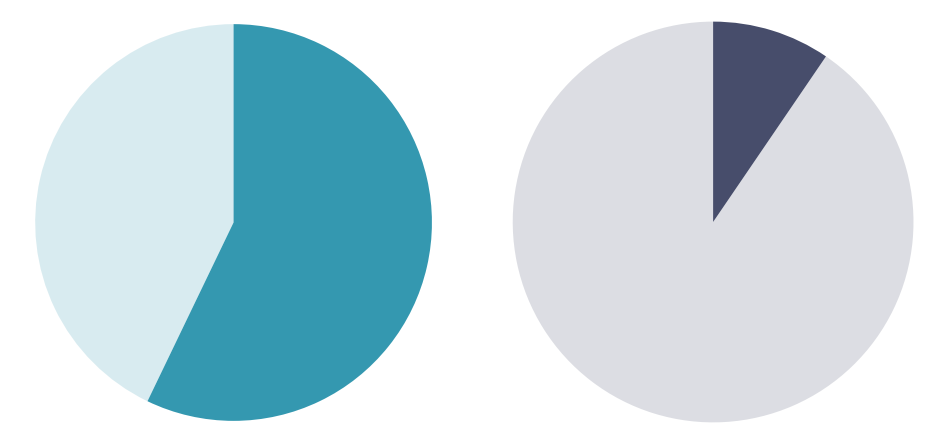

In [3]:
# figure save option
save_option = True
# save_option = False
figsavepath = "../Figures/Figure5_inset.svg"

thresholds = [20]

for threshold in thresholds:
    print(f'\n{threshold}, {threshold/3600}')
    ### Figure Plot ###
    plt.rcParams["font.size"] = 25
    fig, axes = plt.subplots(nrows=1, ncols=2, tight_layout=True, figsize=(10,5))

    # threshold = 25 # arcsec
    win_rate = sum([1 for x in data if x <threshold])/len(data)*100
    win_rate2 = sum([1 for x in data2 if x <threshold])/len(data2)*100

    axes[0].pie([win_rate,100-win_rate], startangle=90, colors = [color2,f'{color2}30'], counterclock=False)
    axes[0].axis('equal')

    axes[1].pie([win_rate2,100-win_rate2], startangle=90, colors = [color1,f'{color1}30'],counterclock=False)
    axes[1].axis('equal')

    print(win_rate,win_rate2)
    print(len(data),len(data2))

    if save_option:
        plt.savefig(figsavepath, dpi=1200, bbox_inches='tight', transparent=True)
    plt.show()

sPV0.18
FWHM: 15.3, R2: 0.9945
sPV0.48
FWHM: 37.4, R2: 0.9961
SLOW: N=42, FAST: N=21
slow
median: 19.572329798204045
iqr: 7.5343954650190526
fast
median: 28.13026365274684
iqr: 14.0486447449912


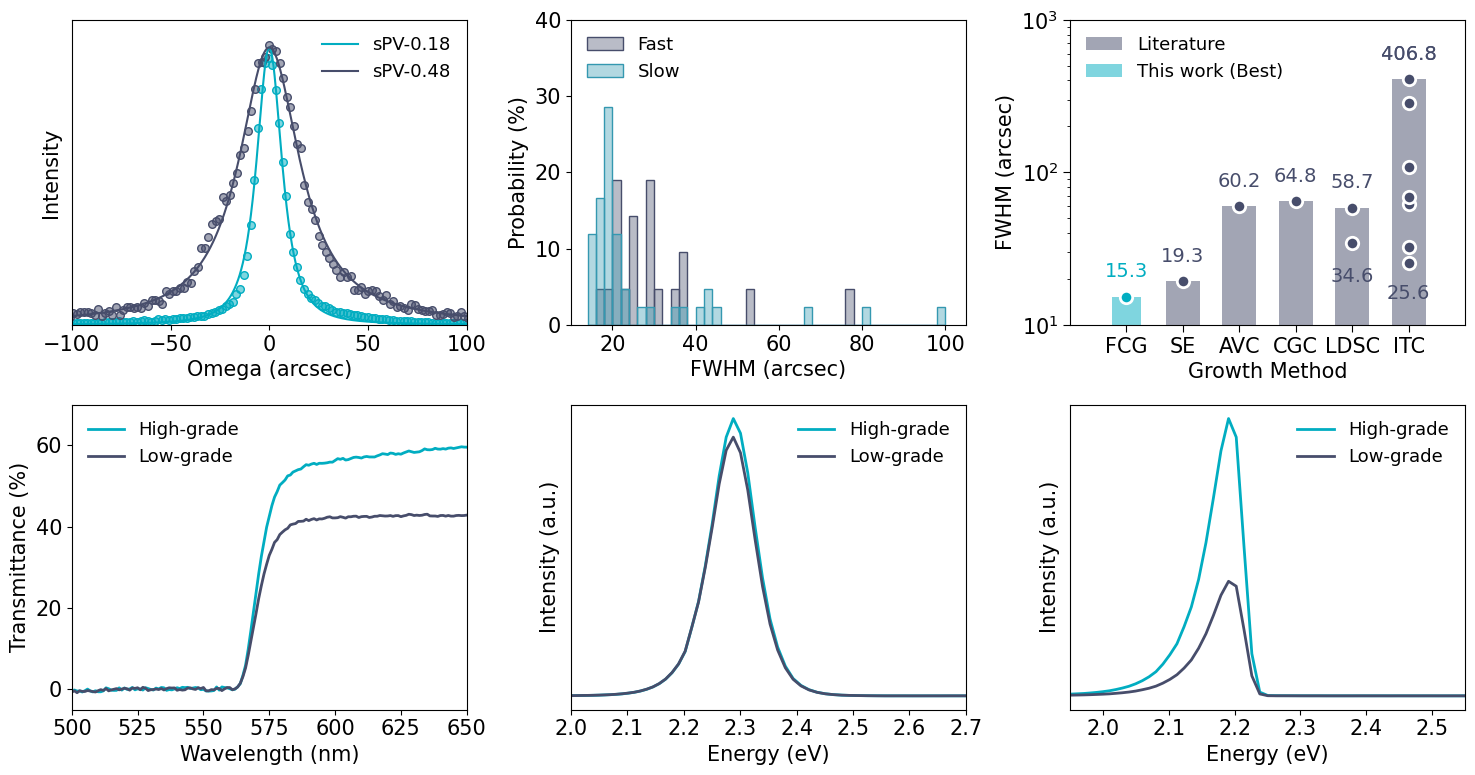

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import wofz, gamma
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# figure save option
save_option = False
figsavepath = "../Figures/Figure5_crystal-evaluation.svg"

# Panel A Representative Rocking Curves
pathA1 = '../Data/Figure5/231010_AY4_0.2mmh_100omega.csv'  #sPV0.18, fwhm15.3, R2 0.995
pathA2 = '../Data/Figure5/230330_A_-0.4mmh-100omega.csv' #sPV0.48, fwhm37.4, R2 0.996

# Panel B FWHM BOX PLOT ###
# check FWHM-analysis.ipynb
pathB1 = '../Data/Figure5/FWHM-analysis.csv'

# Panel C XRC-comparison
pathC = '../Data/Figure5/literature-XRC.xlsx'

# Panel D Transmittance
pathD1 = '../Data/Figure5/230811-A.Sample.csv' # high grade
pathD2 = '../Data/Figure5/230907-D.Sample.csv' # low grade

# Panel E Single-Photon PL
pathE1 = '../Data/Figure5/230811_A_SP_405nm_0.25_power_2.txt' # high grade
pathE2 = '../Data/Figure5/2309007_D_SP_405nm_0.25_power_2.txt' # low grade

# Panel F Two-Photon PL
pathF1 = '../Data/Figure5/230811_A_2P_800nm_0.4_power_inside.txt' # high grade
pathF2 = '../Data/Figure5/2309007_D_2P_800nm_0.4_power_inside.txt' # low grade

# define the PearsonVII function for the fitting of rocking curves
# https://www.originlab.com/doc/Origin-Help/PearsonVII-FitFunc
def PearsonVII(x, xc, y0, A, mu, w):
    y = y0 + A*(2*gamma(mu)*np.sqrt(2**(1/mu)-1))/np.sqrt(np.pi)/gamma(mu-0.5)/w*(1+4*(2**(1/mu)-1)/w/w*(x-xc)**2)**(-mu)
    return y

def fitting(x,y):
    # fit the PearsonVII function to the data
    popt, pcov = curve_fit(PearsonVII, x, y, p0=[0, 0, 30, 1, 30])
    # Fitted Parameters
    xc_fit, y0_fit, A_fit, mu_fit, w_fit = popt
    # Fitting curve
    X = np.arange(np.min(x),np.max(x),0.1)
    Y = PearsonVII(X, *popt)
    # normalize again based on fitting
    x = [n-xc_fit for n in x]
    y = [n/max(Y) for n in y]
    
    ### Second fitting ###
    # fit the PearsonVII function to the data
    popt, pcov = curve_fit(PearsonVII, x, y, p0=[0, 0, 30, 1, 30])
    # Fitted Parameters
    xc_fit, y0_fit, A_fit, mu_fit, w_fit = popt
    
    # calculate R-squared value
    y_fit = PearsonVII(x, *popt)
    R2 = r2_score(y, y_fit)

    # Extract FWHM
    FWHM = w_fit
    # Fitting curve
    X = np.arange(np.min(x),np.max(x),0.1)
    Y = PearsonVII(X, *popt)
    
    print(f'FWHM: {FWHM:.1f}, R2: {R2:.4f}')
    return x, y, X, Y

### Design ###
BG = "#474D6B" # blue gray
LB = "#01ADC1" # light blue
lw = 2 # linewidth for panel D, E, F

### Data read
"""
Panel A
"""
df1 = pd.read_csv(pathA1)
df2 = pd.read_csv(pathA2)
x_a1 = df1['NORM_omega'].to_list()
y_a1 = df1['NORM'].to_list()
x_a2 = df2['NORM_omega'].to_list()
y_a2 = df2['NORM'].to_list()
x_a1 = [n*3600 for n in x_a1]
x_a2 = [n*3600 for n in x_a2]

print('sPV0.18')
x_a1, y_a1, X_a1_fit, Y_a1_fit = fitting(x_a1, y_a1)
print('sPV0.48')
x_a2, y_a2, X_a2_fit, Y_a2_fit = fitting(x_a2, y_a2)

### Figure Plot ###
plt.rcParams["font.size"] = 15
fig, axes = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,8))

# Rocking curves
axes[0][0].plot(X_a1_fit, Y_a1_fit, color='#01ADC1', label='sPV-0.18')
axes[0][0].scatter(x_a1, y_a1, c='#01ADC180',ec='#01ADC1', s=30)
axes[0][0].plot(X_a2_fit, Y_a2_fit, color='#474D6B', label='sPV-0.48')
axes[0][0].scatter(x_a2, y_a2, c='#474D6B80',ec='#474D6B', s=30)
axes[0][0].set_xlabel('Omega (arcsec)')
axes[0][0].set_ylabel('Intensity')
axes[0][0].set_yticks([])
axes[0][0].set_xlim(-100,100)
axes[0][0].set_ylim(0,1.1)
axes[0][0].legend(frameon=False, fontsize=13)

"""
Panel B
"""
df_b = pd.read_csv(pathB1)
x_b1 = df_b['PV'].to_list()
y_b1 = df_b['FWHM'].to_list()

# classify
threshold = 0.3
Y_b1, Y_b2 = [], []
for x, y in zip(x_b1,y_b1):
    if x > threshold:
        Y_b2.append(y)
    else:
        Y_b1.append(y)

print(f'SLOW: N={len(Y_b1)}, FAST: N={len(Y_b2)}')

color1 = "#474D6B" # dark blue
color2 = '#3498B0' # light blue

bin_width = 2
bin_edges = np.arange(start=14, stop=100 + bin_width, step=bin_width)
data = Y_b1.copy()
data2 = Y_b2.copy()
axes[0][1].hist(data2,color=f"{color1}60", ec=color1, bins = bin_edges, weights=np.ones(len(data2)) / len(data2)*100,label='Fast',zorder=1)
axes[0][1].hist(data,color=f"{color2}60", ec=color2, bins = bin_edges, weights=np.ones(len(data)) / len(data)*100,label='Slow',zorder=2)
axes[0][1].set_ylabel('Probability (%)')
axes[0][1].set_xlabel('FWHM (arcsec)')
axes[0][1].legend(loc='upper left', borderaxespad=0.5, frameon=False,fontsize=13)
axes[0][1].set_xlim(10,105)
axes[0][1].set_ylim(0,40)

sPV = ['slow','fast']
Y_b = [Y_b1, Y_b2]
for i in range(2):
    print(sPV[i])
    print(f'median: {np.median(Y_b[i])}')
    q75, q25 = np.percentile(Y_b[i], [75 ,25])
    iqr = q75 - q25
    print(f'iqr: {iqr}')

"""
Panel C
"""
# read data
df4 = pd.read_excel(pathC, sheet_name='Sheet1')
method = df4['Method'].to_list()
fwhm = df4['FWHM'].to_list()

# for bar plot
x4 = ['SE','AVC','CGC','LDSC','ITC']
y4 = [19.3,60.2,64.8,58.7,406.8]
x4_ = ['FCG']
y4_ = [15.3]

# Comparison
axes[0][2].scatter(method[0:1],fwhm[0:1], c="#01ADC1", linewidths=2, ec="white",s=80,zorder=3)
axes[0][2].scatter(method[1:],fwhm[1:], c="#474D6B", linewidths=2, ec="white",s=80,zorder=2)
axes[0][2].bar(x4,y4,width=0.6,color="#474D6B80",zorder=1,label='Literature')
for x, y in zip(x4, y4):
    position = 10**(np.log10(y)+0.1)
    axes[0][2].text(x, position, y, ha='center', va='bottom',color="#474D6B",fontsize=14)
axes[0][2].text(4, 18, '34.6', ha='center', va='bottom',color="#474D6B",fontsize=14) #min for LDSC
axes[0][2].text(5, 14, '25.6', ha='center', va='bottom',color="#474D6B",fontsize=14) #min for LDSC
axes[0][2].text(x, position, y, ha='center', va='bottom',color="#474D6B",fontsize=14)
axes[0][2].bar(x4_,y4_,width=0.5,color="#01ADC180",zorder=1, label='This work (Best)')
position = 10**(np.log10(y4_[0])+0.1)
axes[0][2].text(x4_, position, y4_[0], ha='center', va='bottom',color="#01ADC1",fontsize=14)

axes[0][2].set_yscale('log')
axes[0][2].set_ylim(10,1000)
axes[0][2].set_xlim(-1,6)
axes[0][2].tick_params(length=5)
axes[0][2].set_xlabel('Growth Method')
axes[0][2].set_ylabel('FWHM (arcsec)')
axes[0][2].legend(frameon=False, fontsize=13)


"""
Panel D
"""
df_D1 = pd.read_csv(pathD1,skiprows=1)
df_D2 = pd.read_csv(pathD2,skiprows=1)

LG = df_D1
HG = df_D2

x_d1 = LG['nm'].to_list()
y_d1 = LG[' %T'].to_list()
x_d2 = HG['nm'].to_list()
y_d2 = HG[' %T'].to_list()

axes[1][0].plot(x_d1,y_d1,color='#01ADC1',linewidth=lw, label='High-grade')
axes[1][0].plot(x_d2,y_d2,color='#474D6B',linewidth=lw, label='Low-grade')
axes[1][0].set_xlim(500,650)
axes[1][0].set_ylim(-5,70)
axes[1][0].set_xlabel('Wavelength (nm)')
axes[1][0].set_ylabel('Transmittance (%)')
axes[1][0].legend(frameon=False, fontsize=13)

"""
Panel E
"""
df_E1 = pd.read_csv(pathE1, sep='\t')
df_E2 = pd.read_csv(pathE2, sep='\t')

labels = ['Low-grade','Low-grade','Low-grade','High-grade','High-grade','High-grade']
colors = ['#474D6B','#474D6B','#474D6B','#01ADC1','#01ADC1','#01ADC1']
markers = ['o','o','s','o','o','s']

x = df_E1['Emission wavelength [nm]'].to_list()
x_e1 = [1240/n for n in x] # nm to eV
y = df_E1['Region 1'].to_list()
y_e1 = [n/1000 for n in y]


x = df_E2['Emission wavelength [nm]'].to_list()
x_e2 = [1240/n for n in x] # nm to eV
y = df_E2['Region 1'].to_list()
y_e2 = [n/1000 for n in y]

axes[1][1].plot(x_e2,y_e2,label=labels[5],color=colors[5],linewidth=lw)
axes[1][1].plot(x_e1,y_e1,label=labels[2],color=colors[2],linewidth=lw)

axes[1][1].set_xticks([2,2.1,2.2,2.3,2.4,2.5,2.6,2.7])
axes[1][1].set_yticks([])
axes[1][1].set_xlim(2,2.7)
axes[1][1].set_xlabel("Energy (eV)")
axes[1][1].set_ylabel("Intensity (a.u.)")
axes[1][1].legend(frameon=False, fontsize=13)

"""
Panel F
"""
df_F1 = pd.read_csv(pathF1, sep='\t')
df_F2 = pd.read_csv(pathF2, sep='\t')

labels = ['Low-grade','Low-grade','Low-grade','High-grade','High-grade','High-grade']
colors = ['#474D6B','#474D6B','#474D6B','#01ADC1','#01ADC1','#01ADC1']
markers = ['o','o','s','o','o','s']

x = df_F1['Emission wavelength [nm]'].to_list()
x_f1 = [1240/n for n in x] # nm to eV
y = df_F1['Region 1'].to_list()
y_f1 = [n/1000 for n in y]


x = df_F2['Emission wavelength [nm]'].to_list()
x_f2 = [1240/n for n in x] # nm to eV
y = df_F2['Region 1'].to_list()
y_f2 = [n/1000 for n in y]

axes[1][2].plot(x_f2,y_f2,label=labels[4],color=colors[4],linewidth=lw)
axes[1][2].plot(x_f1,y_f1,label=labels[1],color=colors[1],linewidth=lw)
axes[1][2].set_yticks([])
axes[1][2].set_xlim(1.95,2.55)
axes[1][2].set_xlabel("Energy (eV)")
axes[1][2].set_ylabel("Intensity (a.u.)")
axes[1][2].legend(frameon=False, fontsize=13)

if save_option:
    plt.savefig(figsavepath, dpi=1200, bbox_inches='tight', transparent=True)